# First Simple Model

## Pull & Clean Datasets

In [1]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('Data/hate_speech_training.csv')
df_train_2 = pd.read_csv('Data/hate_speech_training_2.csv')
df_train_3 = pd.read_csv('Data/hate_speech_training_3.csv')
df_train_4 = pd.read_csv('Data/hate_speech_training_4.tsv', sep = '\t')
df_train_5 = pd.read_csv('Data/hate_speech_training_5.csv')
df_test = pd.read_csv('Data/hate_speech_test.csv')

In [3]:
df_train = df_train.drop('id', axis = 1) #0 = Not Hate Speech, 1 = Hate Speech

In [4]:
df_train_2 = df_train_2[['tweet', 'class']]
df_train_2['class'] = df_train_2['class'].replace([0], 'hate speech')
df_train_2['class'] = df_train_2['class'].replace([1, 2], 'not hate speech')
df_train_2['class'] = df_train_2['class'].replace(['hate speech'], 1)
df_train_2['class'] = df_train_2['class'].replace(['not hate speech'], 0)
df_train_2.rename(columns = {'class': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [5]:
df_train_3 = df_train_3.drop('index', axis = 1) 
df_train_3.rename(columns = {'post': 'tweet'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [6]:
df_train_4 = df_train_4[['text', 'HS']] 
df_train_4.rename(columns = {'text': 'tweet', 'HS': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [7]:
df_train_5['Label'] = df_train_5['Label'].replace(['Hate', 'Non-Asian Aggression'], 1)
df_train_5['Label'] = df_train_5['Label'].replace(['Neutral', 'Counterhate'], 0) 
df_train_5.rename(columns = {'Text': 'tweet', 'Label': 'label'}, inplace = True) #0 = Not Hate Speech, 1 = Hate Speech

In [8]:
dfs = [df_train, df_train_2, df_train_3, df_train_4, df_train_5]
df = pd.concat(dfs)

## Train, Test, Split

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = df['tweet']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=3,
                                                    test_size=0.20,
                                                   stratify = y) #80/20 split

## Natural Language Processing (NLP)

The goal here will actually to be to not only use grid searches but to also test both TF-IDF (Term Frequency - Inverse Document Frequency) and Count Vectorizers to see which performs better with each model

### TF-IDF  & Count Vectorizer

In [11]:
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [12]:
sw = stopwords.words('english')

In [13]:
def get_wordnet_pos(treebank_tag):
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [14]:
def doc_preparer(doc, stop_words=sw):
 
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [15]:
token_docs = [doc_preparer(doc, sw) for doc in X_train]

In [16]:
token_test_docs = [doc_preparer(doc, sw) for doc in X_test]

In [17]:
tfidf = TfidfVectorizer()

In [18]:
X_final_t_vec = tfidf.fit_transform(token_docs)
X_final_t_vec = pd.DataFrame.sparse.from_spmatrix(X_final_t_vec)
X_final_t_vec.columns = sorted(tfidf.vocabulary_)
X_final_t_vec.set_index(y_train.index, inplace=True)

In [19]:
X_final_test_vec = tfidf.transform(token_test_docs)
X_final_test_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_vec)
X_final_test_vec.columns = sorted(tfidf.vocabulary_)
X_final_test_vec.set_index(y_test.index, inplace=True)

In [20]:
cv = CountVectorizer()

In [21]:
X_final_c_vec = cv.fit_transform(token_docs)
X_final_c_vec = pd.DataFrame.sparse.from_spmatrix(X_final_c_vec)
X_final_c_vec.columns = sorted(cv.vocabulary_)
X_final_c_vec.set_index(y_train.index, inplace=True)

In [22]:
X_final_test_c_vec = cv.transform(token_test_docs)
X_final_test_c_vec  = pd.DataFrame.sparse.from_spmatrix(X_final_test_c_vec)
X_final_test_c_vec.columns = sorted(cv.vocabulary_)
X_final_test_c_vec.set_index(y_test.index, inplace=True)

## Simple First Dummy Model on TF-IDF and Count Vectorizer

### TF-IDF Simple Dummy Model


In [23]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
df_tfidf = DummyClassifier(strategy = 'most_frequent')
df_tfidf.fit(X_final_t_vec, y_train)

DummyClassifier(strategy='most_frequent')

In [24]:
df_tfidf.score(X_final_t_vec, y_train)

0.9149463552314957

In [25]:
cross_val_score(df_tfidf, X_final_t_vec, y_train, cv = 5)

array([0.91488014, 0.91496291, 0.91496291, 0.91496291, 0.91496291])

In [26]:
df_tfidf.score(X_final_test_vec, y_test)

0.9149659863945578

In [27]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report

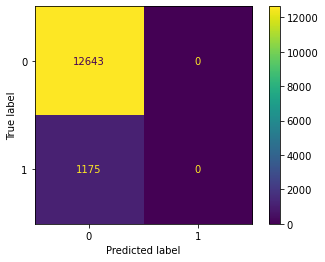

In [28]:
plot_confusion_matrix(df_tfidf, X_final_test_vec, y_test)

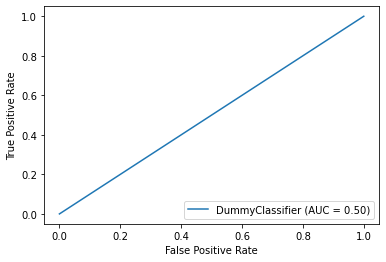

In [29]:
plot_roc_curve(df_tfidf, X_final_test_vec, y_test)

In [30]:
y_hat = df_tfidf.predict(X_final_test_vec)
print(classification_report(y_pred = y_hat, y_true = y_test))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     12643
           1       0.00      0.00      0.00      1175

    accuracy                           0.91     13818
   macro avg       0.46      0.50      0.48     13818
weighted avg       0.84      0.91      0.87     13818



### Count Vectorizer Simple Dummy Model

In [31]:
df_cv = DummyClassifier(strategy = 'most_frequent')
df_cv.fit(X_final_c_vec, y_train)

DummyClassifier(strategy='most_frequent')

In [32]:
df_cv.score(X_final_c_vec, y_train)

0.9149463552314957

In [33]:
cross_val_score(df_cv, X_final_c_vec, y_train, cv = 5)

array([0.91488014, 0.91496291, 0.91496291, 0.91496291, 0.91496291])

In [34]:
df_cv.score(X_final_test_c_vec, y_test)

0.9149659863945578

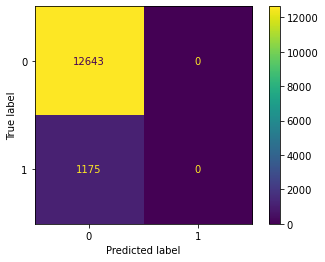

In [35]:
plot_confusion_matrix(df_cv, X_final_test_c_vec, y_test)

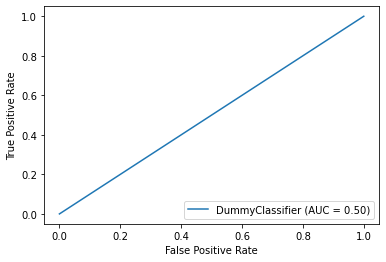

In [36]:
plot_roc_curve(df_cv, X_final_test_c_vec, y_test)

In [37]:
y_hat_2 = df_cv.predict(X_final_test_c_vec)
print(classification_report(y_pred = y_hat_2, y_true = y_test))

              precision    recall  f1-score   support

           0       0.91      1.00      0.96     12643
           1       0.00      0.00      0.00      1175

    accuracy                           0.91     13818
   macro avg       0.46      0.50      0.48     13818
weighted avg       0.84      0.91      0.87     13818

